## **Marketing Campaign**

Context
A response model can provide a significant boost to the efficiency of a marketing campaign by increasing responses or reducing expenses. The objective is to predict who will respond to an offer for a product or service

Content
AcceptedCmp1 - 1 if customer accepted the offer in the 1st campaign, 0 otherwise

AcceptedCmp2 - 1 if customer accepted the offer in the 2nd campaign, 0 otherwise

AcceptedCmp3 - 1 if customer accepted the offer in the 3rd campaign, 0 otherwise

AcceptedCmp4 - 1 if customer accepted the offer in the 4th campaign, 0 otherwise

AcceptedCmp5 - 1 if customer accepted the offer in the 5th campaign, 0 otherwise

Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise

Complain - 1 if customer complained in the last 2 years

DtCustomer - date of customer’s enrolment with the company

Education - customer’s level of education

Marital - customer’s marital status

Kidhome - number of small children in customer’s household

Teenhome - number of teenagers in customer’s household

Income - customer’s yearly household income

MntFishProducts - amount spent on fish products in the last 2 years

MntMeatProducts - amount spent on meat products in the last 2 years

MntFruits - amount spent on fruits products in the last 2 years

MntSweetProducts - amount spent on sweet products in the last 2 years

MntWines - amount spent on wine products in the last 2 years

MntGoldProds - amount spent on gold products in the last 2 years

NumDealsPurchases - number of purchases made with discount

NumCatalogPurchases - number of purchases made using catalogue

NumStorePurchases - number of purchases made directly in stores

NumWebPurchases - number of purchases made through company’s web site

NumWebVisitsMonth - number of visits to company’s web site in the last month

Recency - number of days since the last purchase

Acknowledgements
O. Parr-Rud. Business Analytics Using SAS Enterprise Guide and SAS Enterprise Miner. SAS Institute, 2014.

Inspiration
**The main objective is to train a predictive model which allows the company to maximize the profit of the next marketing campaign.**

In [268]:
#Importing libraries
import pandas as pd
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
from datetime import date
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from dtreeviz.trees import dtreeviz
from matplotlib.colors import ListedColormap

#### **Data Analysis**

In [269]:
#Reading dataframe
data = pd.read_csv('C:\\Users\\Asus\\Desktop\\marketing\\data\\marketing_campaign.csv',sep=';')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


#### **Functions and Classes**

In [270]:
#Data check
def data_check(df):
    print('dataframe shape', df.shape)
    print()
    print(df.describe())
    print()
    print('Dataframe NaN Values')
    print(df.isna().sum())
    print()
    print(df.info())

    
def categorical_check(data):
    return data.describe(include=[np.object])


#Generation function
def generations(year):
    if year <= 1915:
        return 'Lost Generation'
    elif year >= 1916 and year <= 1924:
        return 'The Greatest Generation'
    elif year >= 1925 and year <= 1945:
        return 'The Silent Generation'
    elif year >= 1946 and year <=1963:
        return 'Baby Boomer Generation'
    elif year >= 1964 and year <=1979:
        return 'Generation X'
    elif year >= 1980 and year <=1993:
        return 'Millenials'
    else: 
        return 'Generation Z'
    

#Predicted Label Change
def checkFunc(value):
    if value == True:
        return 'Corrrectly Predicted'
    else:
        return 'Not Correctly Predicted'
    
    
# Customer Segmentation
def clusters(Kmeans):
    if Kmeans == 0:
        return 'Loyal'
    elif Kmeans == 1:
        return '5-Star'
    elif Kmeans == 2:
        return 'Need Attention'
    else:
        return 'Highest Potential'

#### **1.1 Data Check**

checking data before any wrangling or analysis.

In [271]:
# Calling data check function
data_check(data)

dataframe shape (2240, 29)

                 ID   Year_Birth         Income      Kidhome     Teenhome  \
count   2240.000000  2240.000000    2216.000000  2240.000000  2240.000000   
mean    5592.159821  1968.805804   52247.251354     0.444196     0.506250   
std     3246.662198    11.984069   25173.076661     0.538398     0.544538   
min        0.000000  1893.000000    1730.000000     0.000000     0.000000   
25%     2828.250000  1959.000000   35303.000000     0.000000     0.000000   
50%     5458.500000  1970.000000   51381.500000     0.000000     0.000000   
75%     8427.750000  1977.000000   68522.000000     1.000000     1.000000   
max    11191.000000  1996.000000  666666.000000     2.000000     2.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2240.000000  2240.000000  2240.000000      2240.000000   
mean     49.109375   303.935714    26.302232       166.950000   
std      28.962453   336.597393    39.773434       225.715373   
min       0.000000

**Income** is the only column with NaN values, so let´s replace it with the mean of the column.

In [272]:
#Replacing Empty values with mean
data.Income.fillna(data.Income.mean(),inplace=True)

In [273]:
#Calling the categorical data function, to observe categorical variables summay
categorical_check(data)

,Education,Marital_Status,Dt_Customer
count,2240,2240,2240
unique,5,8,663
top,Graduation,Married,2012-08-31
freq,1127,864,12


**Dt_customer** column have dtype object. let´s change it to datatime

In [274]:
#Converting it into datetime format
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])

In [275]:
#Creating new columns based on the time info
data['Year'] = data.Dt_Customer.dt.year
data['Month'] = data.Dt_Customer.dt.month
data['Day'] = data.Dt_Customer.dt.day

#Creating a Column for count of values
data['trend'] = 1

In [276]:
#Creating a column with generations
data['Generation'] = data['Year_Birth'].apply(generations)

In [277]:
#reorder column
data = data[['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer','Year', 'Month', 'Day', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue','Generation',
        'trend','Response']]

In [278]:
#FILTERING BY YEARS
twelve = data[data['Year']==2012]
thirteen = data[data['Year']==2013]
fourteen =data[data['Year']==2014]

In [279]:
#Final dataset view
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Year,Month,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Generation,trend,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,2012,9,...,0,0,0,0,0,3,11,Baby Boomer Generation,1,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,2014,3,...,0,0,0,0,0,3,11,Baby Boomer Generation,1,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,2013,8,...,0,0,0,0,0,3,11,Generation X,1,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,2014,2,...,0,0,0,0,0,3,11,Millenials,1,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,2014,1,...,0,0,0,0,0,3,11,Millenials,1,0


#### **1.3 Data Visualization and Insights**

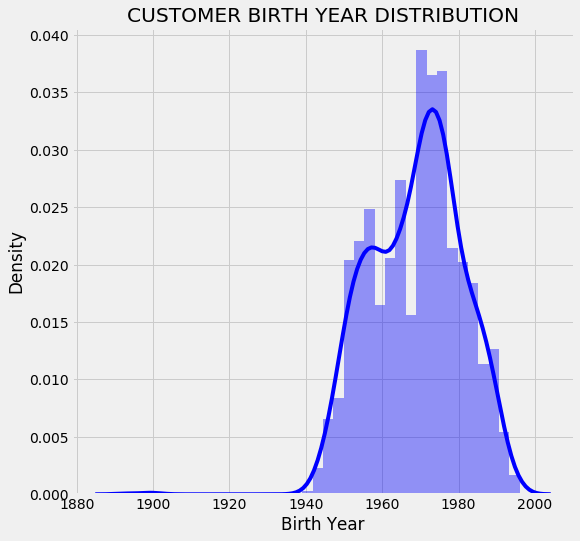

In [280]:
plt.figure(figsize=(8,8))
sns.distplot(data['Year_Birth'],color='blue')
plt.xlabel('Birth Year')
plt.ylabel('Density')
plt.title('CUSTOMER BIRTH YEAR DISTRIBUTION')
plt.show()

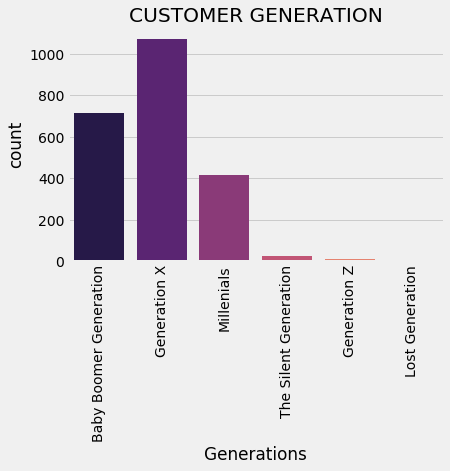

In [281]:
#  Customer Generation.
sns.countplot(data= data, x='Generation',palette='magma')
plt.xlabel('Generations')
plt.xticks(rotation=90)
plt.title('CUSTOMER GENERATION')
plt.show()

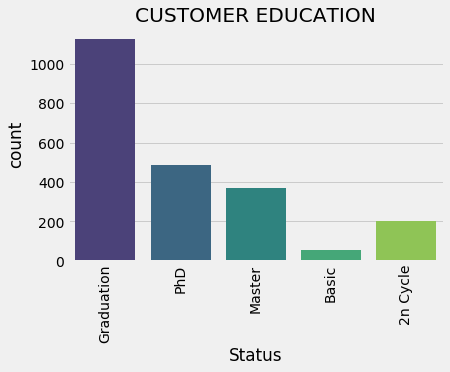

In [282]:
#Marital Status.
sns.countplot(data=data, x='Education',palette='viridis')
plt.title('CUSTOMER EDUCATION')
plt.xlabel('Status')
plt.xticks(rotation=90)
plt.show()

Must costumere were born between 1965 - 1980

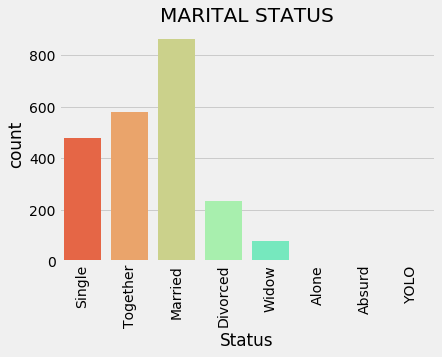

In [283]:
sns.countplot(data=data, x='Marital_Status',palette='rainbow_r')
plt.title('MARITAL STATUS')
plt.xlabel('Status')
plt.xticks(rotation=90)
plt.show()

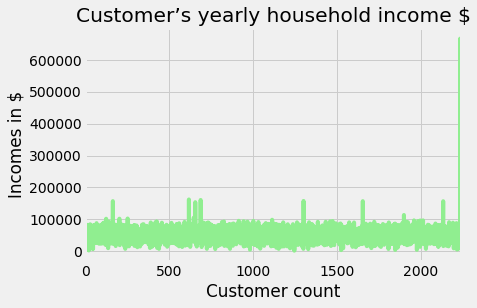

In [284]:
data.Income.plot(color='lightgreen')
plt.title('Customer’s yearly household income $')
plt.ylabel('Incomes in $')
plt.xlabel('Customer count')
plt.show()

Majority of customer yearly income is bewtween 0.00 - 100k

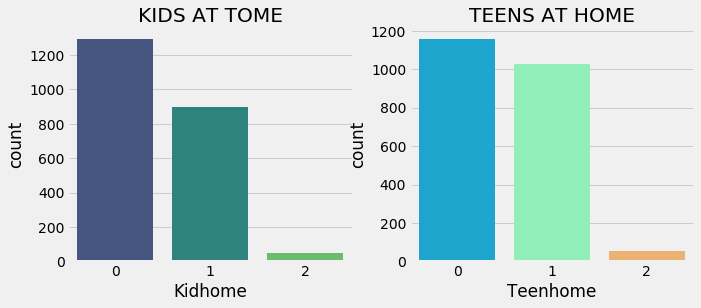

In [285]:
fig = plt.figure(figsize=(10,4))
#  subplot #1
plt.subplot(121)
plt.title('KIDS AT TOME')
sns.countplot(data = data, x = 'Kidhome', palette='viridis')
#  subplot #2
plt.subplot(122)
plt.title('TEENS AT HOME')
sns.countplot(data = data, x = 'Teenhome',palette='rainbow')

plt.show()

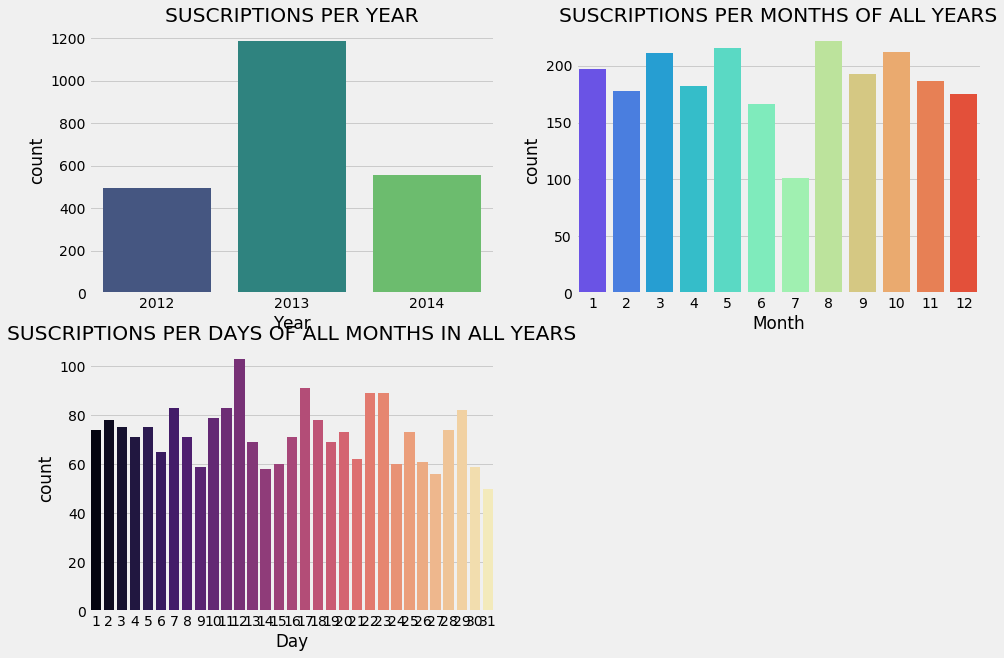

In [286]:
fig = plt.figure(figsize=(22,10))
#  subplot #1
plt.subplot(231)
plt.title('SUSCRIPTIONS PER YEAR')
sns.countplot(data = data, x = 'Year', palette='viridis')
#  subplot #2
plt.subplot(232)
plt.title('SUSCRIPTIONS PER MONTHS OF ALL YEARS')
sns.countplot(data = data, x = 'Month',palette='rainbow')

#  subplot #3
plt.subplot(234)
plt.title('SUSCRIPTIONS PER DAYS OF ALL MONTHS IN ALL YEARS')
sns.countplot(data = data, x = 'Day',palette='magma')
plt.show()

#### Year 2012

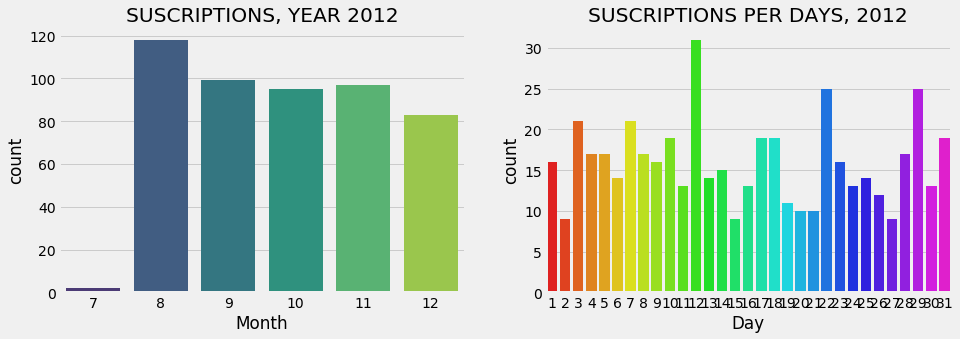

In [287]:
fig = plt.figure(figsize=(22,10))
#  subplot #1
plt.subplot(231)
plt.title('SUSCRIPTIONS, YEAR 2012')
sns.countplot(data = twelve, x = 'Month', palette='viridis')
#  subplot #2
plt.subplot(232)
plt.title('SUSCRIPTIONS PER DAYS, 2012')
sns.countplot(data = twelve, x = 'Day',palette='gist_rainbow')
plt.show()

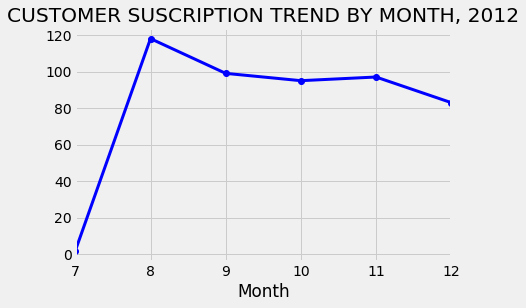

In [288]:
twelvetrend = twelve.groupby(by=['Month']).sum()
twelvetrend.trend.plot(color='blue',marker='o',linestyle='-',linewidth=3.0)
plt.title('CUSTOMER SUSCRIPTION TREND BY MONTH, 2012')
plt.xticks(twelvetrend.index)
plt.show()

#### **Year 2013**

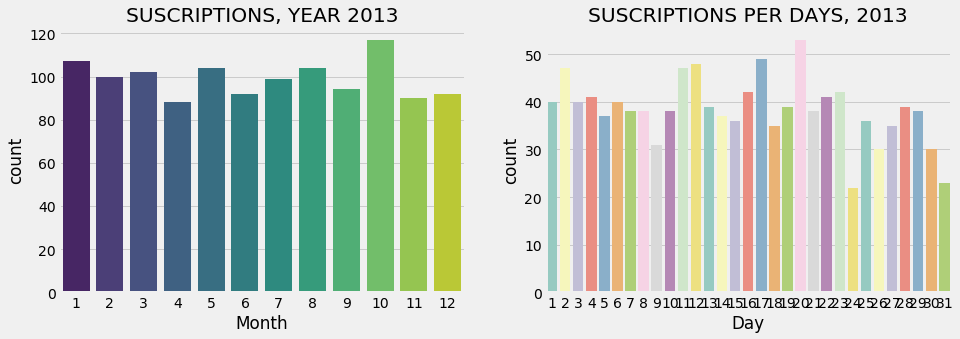

In [289]:
fig = plt.figure(figsize=(22,10))
#  subplot #1
plt.subplot(231)
plt.title('SUSCRIPTIONS, YEAR 2013')
sns.countplot(data = thirteen, x = 'Month', palette='viridis')
#  subplot #2
plt.subplot(232)
plt.title('SUSCRIPTIONS PER DAYS, 2013')
sns.countplot(data = thirteen, x = 'Day',palette='Set3')
plt.show()

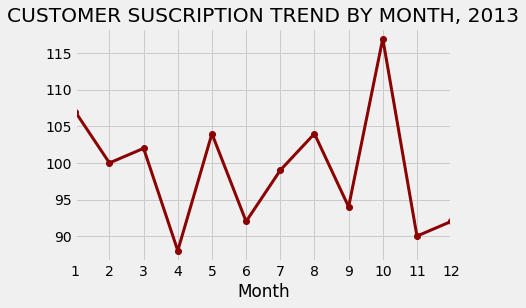

In [290]:
thirteentrend = thirteen.groupby(by=['Month']).sum()
thirteentrend.trend.plot(color='darkred',marker='o',linestyle='-',linewidth=3.0)
plt.title('CUSTOMER SUSCRIPTION TREND BY MONTH, 2013')
plt.xticks(thirteentrend.index)
plt.show()

#### **Year 2014**

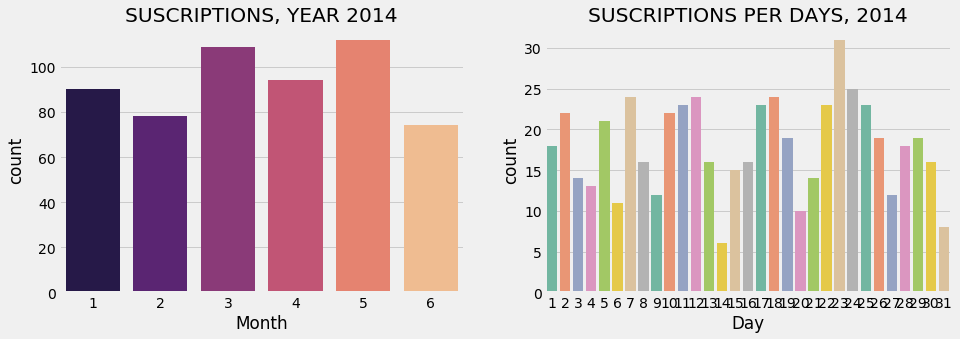

In [291]:
fig = plt.figure(figsize=(22,10))
#  subplot #1
plt.subplot(231)
plt.title('SUSCRIPTIONS, YEAR 2014')
sns.countplot(data = fourteen, x = 'Month', palette='magma')
#  subplot #2
plt.subplot(232)
plt.title('SUSCRIPTIONS PER DAYS, 2014')
sns.countplot(data = fourteen, x = 'Day',palette='Set2')
plt.show()

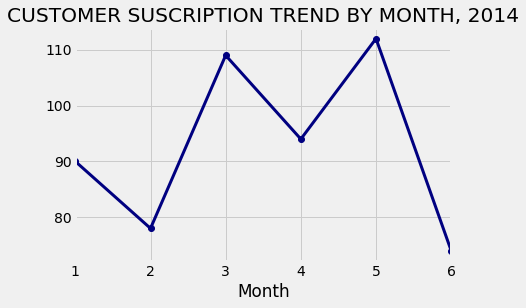

In [292]:
fourteentrend = fourteen.groupby(by=['Month']).sum()
fourteentrend.trend.plot(color='navy',marker='o',linestyle='-',linewidth=3.0,)
plt.title('CUSTOMER SUSCRIPTION TREND BY MONTH, 2014')
plt.xticks(fourteentrend.index)
plt.show()

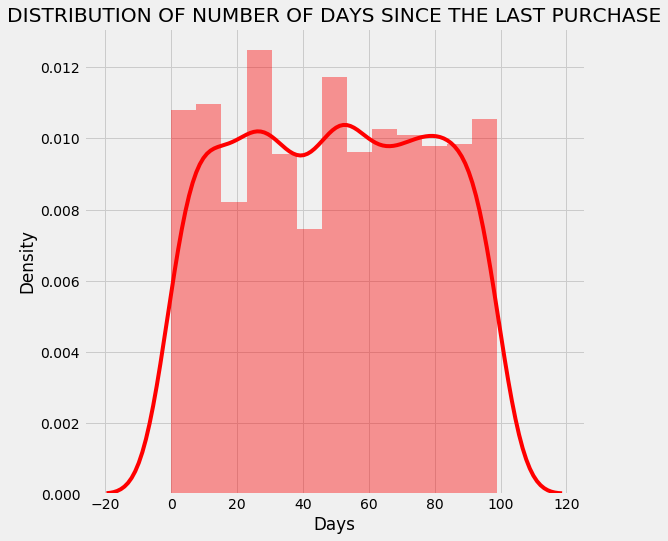

In [293]:
#Days since the last purchase distribution.
plt.figure(figsize=(8,8))
sns.distplot(data['Recency'],color='red')
plt.xlabel('Days')
plt.ylabel('Density')
plt.title('DISTRIBUTION OF NUMBER OF DAYS SINCE THE LAST PURCHASE')
plt.show()

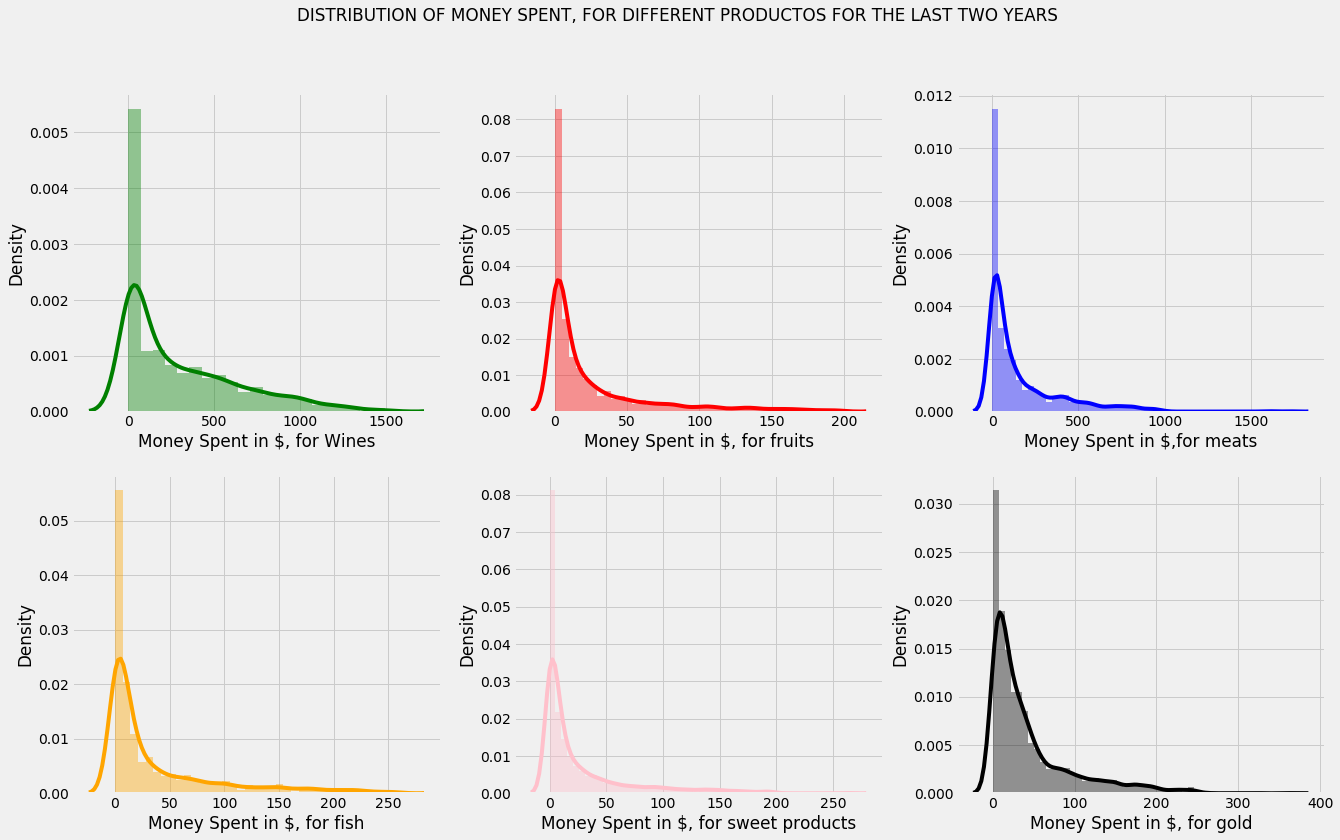

In [294]:
fig = plt.figure(figsize=(20,12))
plt.suptitle('DISTRIBUTION OF MONEY SPENT, FOR DIFFERENT PRODUCTOS FOR THE LAST TWO YEARS')
#  subplot #1
plt.subplot(231)
sns.distplot(data['MntWines'],color='green')
plt.xlabel('Money Spent in $, for Wines')
plt.ylabel('Density')


#  subplot #2
plt.subplot(232)
sns.distplot(data['MntFruits'],color='red')
plt.xlabel('Money Spent in $, for fruits')
plt.ylabel('Density')



#  subplot #3
plt.subplot(233)
sns.distplot(data['MntMeatProducts'],color='blue')
plt.xlabel('Money Spent in $,for meats')
plt.ylabel('Density')



# subplot #4
plt.subplot(234)
sns.distplot(data['MntFishProducts'],color='orange')
plt.xlabel('Money Spent in $, for fish')
plt.ylabel('Density')


# subplot #5
plt.subplot(235)
sns.distplot(data['MntSweetProducts'],color='pink')
plt.xlabel('Money Spent in $, for sweet products')
plt.ylabel('Density')



# subplot #6
plt.subplot(236)
sns.distplot(data['MntGoldProds'],color='black')
plt.xlabel('Money Spent in $, for gold')
plt.ylabel('Density')



plt.show()

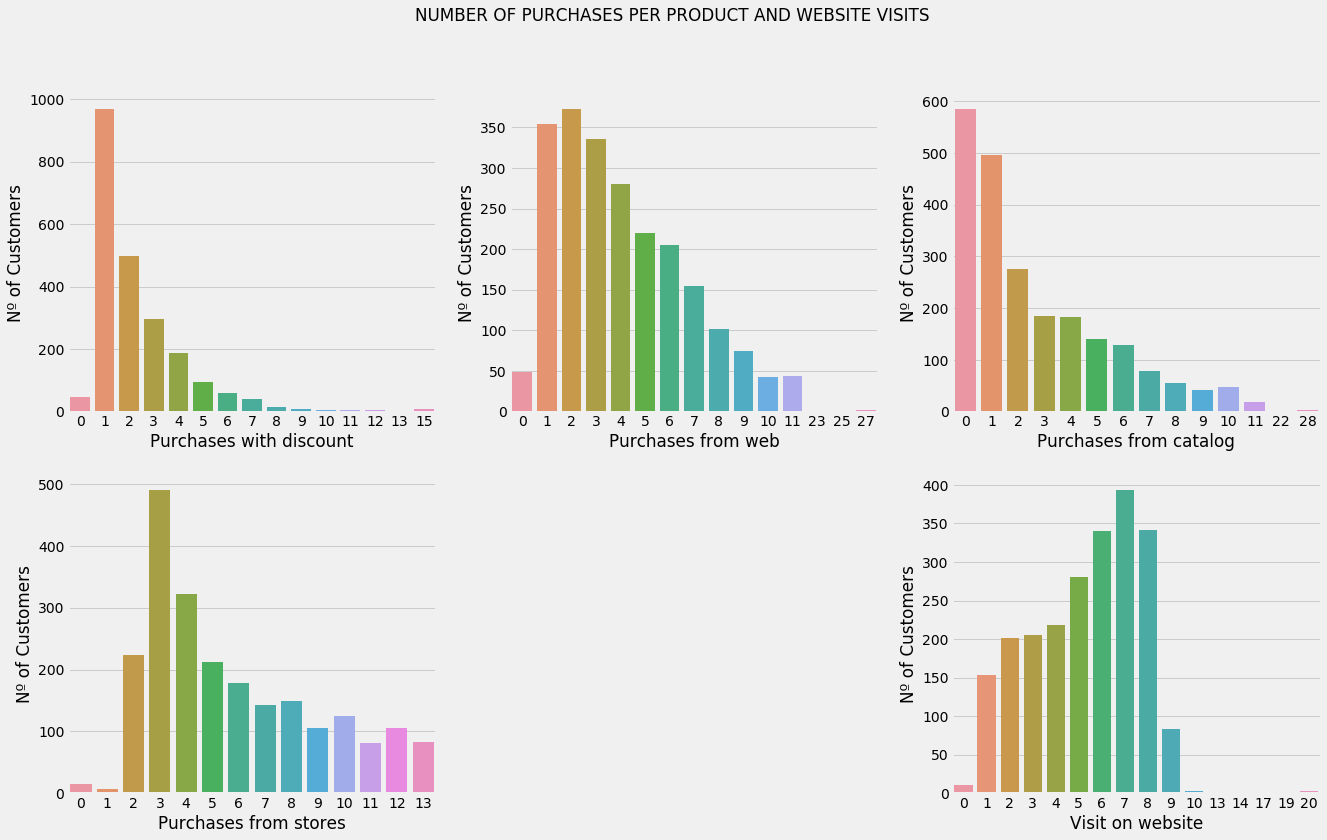

In [334]:
fig = plt.figure(figsize=(20,12))
plt.suptitle('NUMBER OF PURCHASES PER PRODUCT AND WEBSITE VISITS')
#  subplot #1
plt.subplot(231)
sns.countplot(data=data, x='NumDealsPurchases')
plt.xlabel('Purchases with discount')
plt.ylabel('Nº of Customers')


#  subplot #2
plt.subplot(232)
sns.countplot(data=data, x='NumWebPurchases')
plt.xlabel('Purchases from web')
plt.ylabel('Nº of Customers')


#  subplot #3
plt.subplot(233)
sns.countplot(data=data, x='NumCatalogPurchases')
plt.xlabel('Purchases from catalog')
plt.ylabel('Nº of Customers')



# subplot #4
plt.subplot(234)
sns.countplot(data=data, x='NumStorePurchases')
plt.xlabel('Purchases from stores')
plt.ylabel('Nº of Customers')


# subplot #5
plt.subplot(236)
sns.countplot(data=data, x='NumWebVisitsMonth')
plt.xlabel('Visit on website')
plt.ylabel('Nº of Customers')


plt.show()

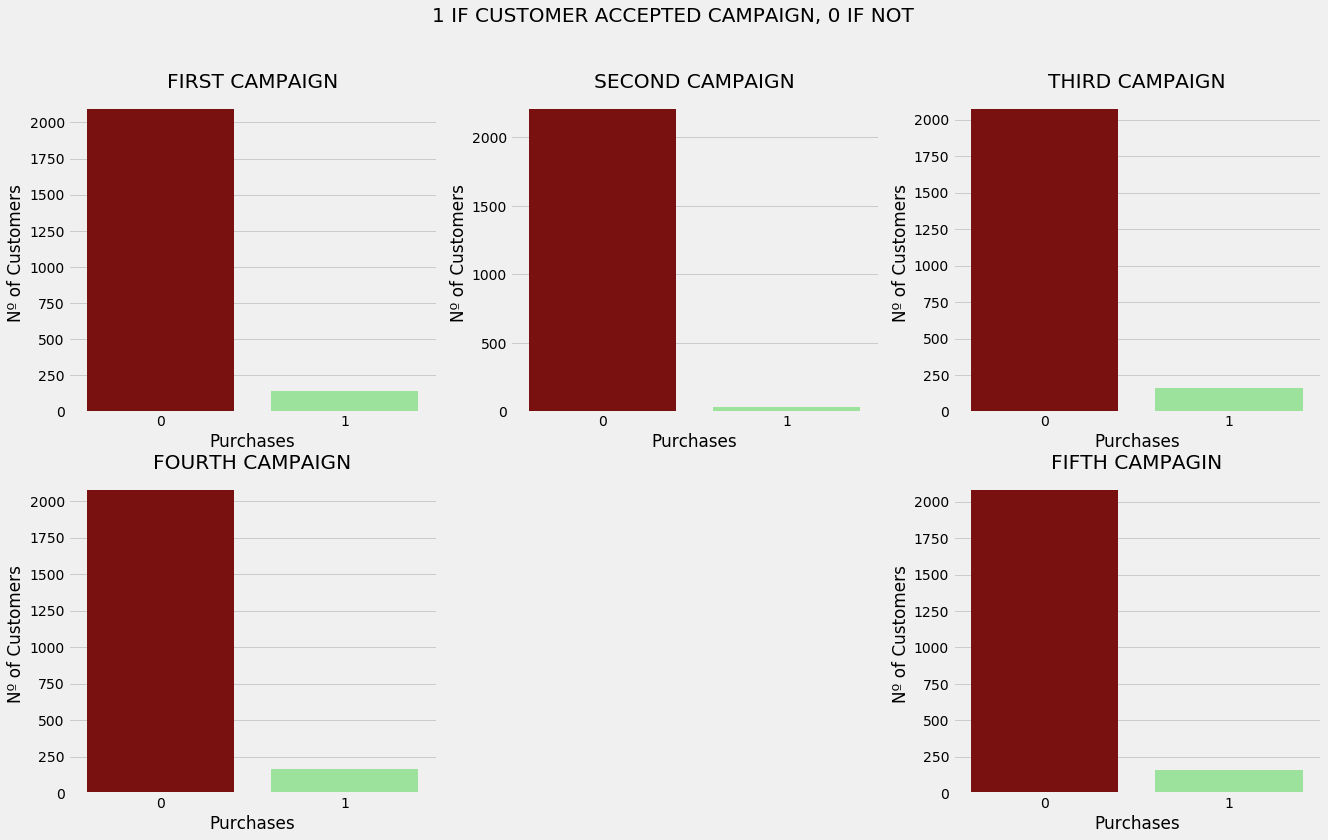

In [296]:
fig = plt.figure(figsize=(20,12))
plt.suptitle('1 IF CUSTOMER ACCEPTED CAMPAIGN, 0 IF NOT',size=20)
c_color = ['darkred','lightgreen']
#  subplot #1
plt.subplot(231)
sns.countplot(data=data, x='AcceptedCmp1',palette=c_color)
plt.xlabel('Purchases')
plt.ylabel('Nº of Customers')
plt.title('FIRST CAMPAIGN')

#  subplot #2
plt.subplot(232)
sns.countplot(data=data, x='AcceptedCmp2',palette=c_color)
plt.xlabel('Purchases')
plt.ylabel('Nº of Customers')
plt.title('SECOND CAMPAIGN')


#  subplot #3
plt.subplot(233)
sns.countplot(data=data, x='AcceptedCmp3',palette=c_color)
plt.xlabel('Purchases')
plt.ylabel('Nº of Customers')
plt.title('THIRD CAMPAIGN')


# subplot #4
plt.subplot(234)
sns.countplot(data=data, x='AcceptedCmp4',palette=c_color)
plt.xlabel('Purchases')
plt.ylabel('Nº of Customers')
plt.title('FOURTH CAMPAIGN')

# subplot #5
plt.subplot(236)
sns.countplot(data=data, x='AcceptedCmp5',palette=c_color)
plt.xlabel('Purchases')
plt.ylabel('Nº of Customers')
plt.title('FIFTH CAMPAGIN')


plt.show()

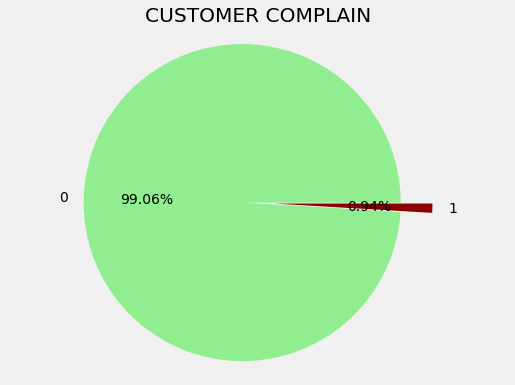

In [297]:
#Customer Complain
complain = data['Complain'].value_counts()
complain_color = ['lightgreen','darkred']
plt.figure(figsize=(8,6))
plt.pie(complain,labels=complain.index,autopct='%1.2f%%',explode=(0.1,0.1),colors=complain_color)
plt.title('CUSTOMER COMPLAIN')
plt.axis('equal')
plt.show()

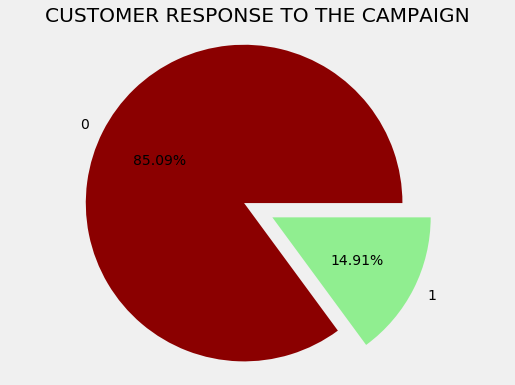

In [298]:
#Customer Complain
response = data['Response'].value_counts()
response_color = ['darkred','lightgreen']
plt.figure(figsize=(8,6))
plt.pie(response,labels=response.index,autopct='%1.2f%%',explode=(0.1,0.1),colors=response_color)
plt.title('CUSTOMER RESPONSE TO THE CAMPAIGN')
plt.axis('equal')
plt.show()

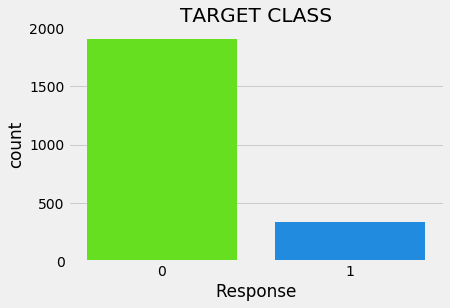

In [299]:
#Target Class
sns.countplot(data = data, x = 'Response',palette='gist_rainbow')
plt.title('TARGET CLASS')
plt.show()

**Umbalanced Target Class**

#### **1.4 Preparing Data For the model**

In [300]:
# Creating an alternaative df to use.
model_df = data

#dropping columns
model_df = model_df.drop(columns=['ID','trend','Z_CostContact','Z_Revenue','Dt_Customer'])

# Creating Dummy variables.
model_df = pd.get_dummies(model_df)

In [301]:
#Separating Variables
X = model_df.drop(columns=['Response'])
y = model_df['Response']

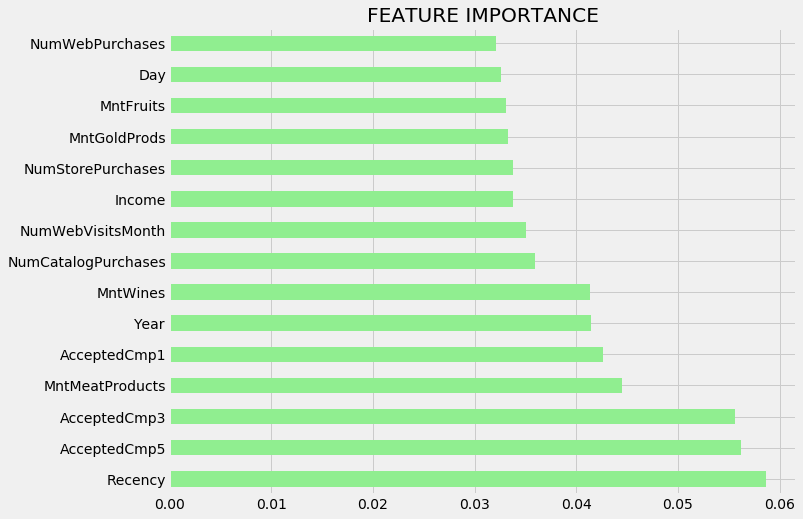

In [302]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(random_state=0)
model.fit(X,y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,8))
feat_importances.nlargest(15).plot(kind='barh',color='lightgreen')
plt.title('FEATURE IMPORTANCE')
plt.show()

#### **1.5 Train and Test Dataset**

In [303]:
#Let´s oversample the target class
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X,y)

#Let´s check the data shape
print('Attibutes shape: ',X_smote.shape)
print('Target shape:    ',y_smote.shape)

# Creating variables for the final test set.
X_dev, y_dev = X_smote, y_smote

Attibutes shape:  (3812, 44)
Target shape:     (3812,)


In [304]:
#Creating a Final test set, to test the model
X_smote = X_smote.iloc[382:]
y_smote = y_smote.iloc[382:]

#Selecting first 800 rows to final test set
X_dev = X_dev.iloc[0:381]
y_dev = y_dev.iloc[0:381]

In [305]:
#Let´s check the data shape
print('Attibutes shape: ',X_dev.shape)
print('Target shape:    ',y_dev.shape)

Attibutes shape:  (381, 44)
Target shape:     (381,)


#### **1.6 Models**

In [306]:
#Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.30,random_state=0)

#### **Random Forest Classifier**

In [307]:
#RANDOM FOREST MODEL
random_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
random_classifier.fit(X_train, y_train)
random_prediction = random_classifier.predict(X_test)
    
#Model Accuracy
print('RANDOM FOREST CLASSIFIER')
print(confusion_matrix(y_test, random_prediction))
print(classification_report(y_test, random_prediction))
print('Model Accuracy: ',accuracy_score(y_test, random_prediction))

RANDOM FOREST CLASSIFIER
[[470  24]
 [ 29 506]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       494
           1       0.95      0.95      0.95       535

    accuracy                           0.95      1029
   macro avg       0.95      0.95      0.95      1029
weighted avg       0.95      0.95      0.95      1029

Model Accuracy:  0.9484936831875608


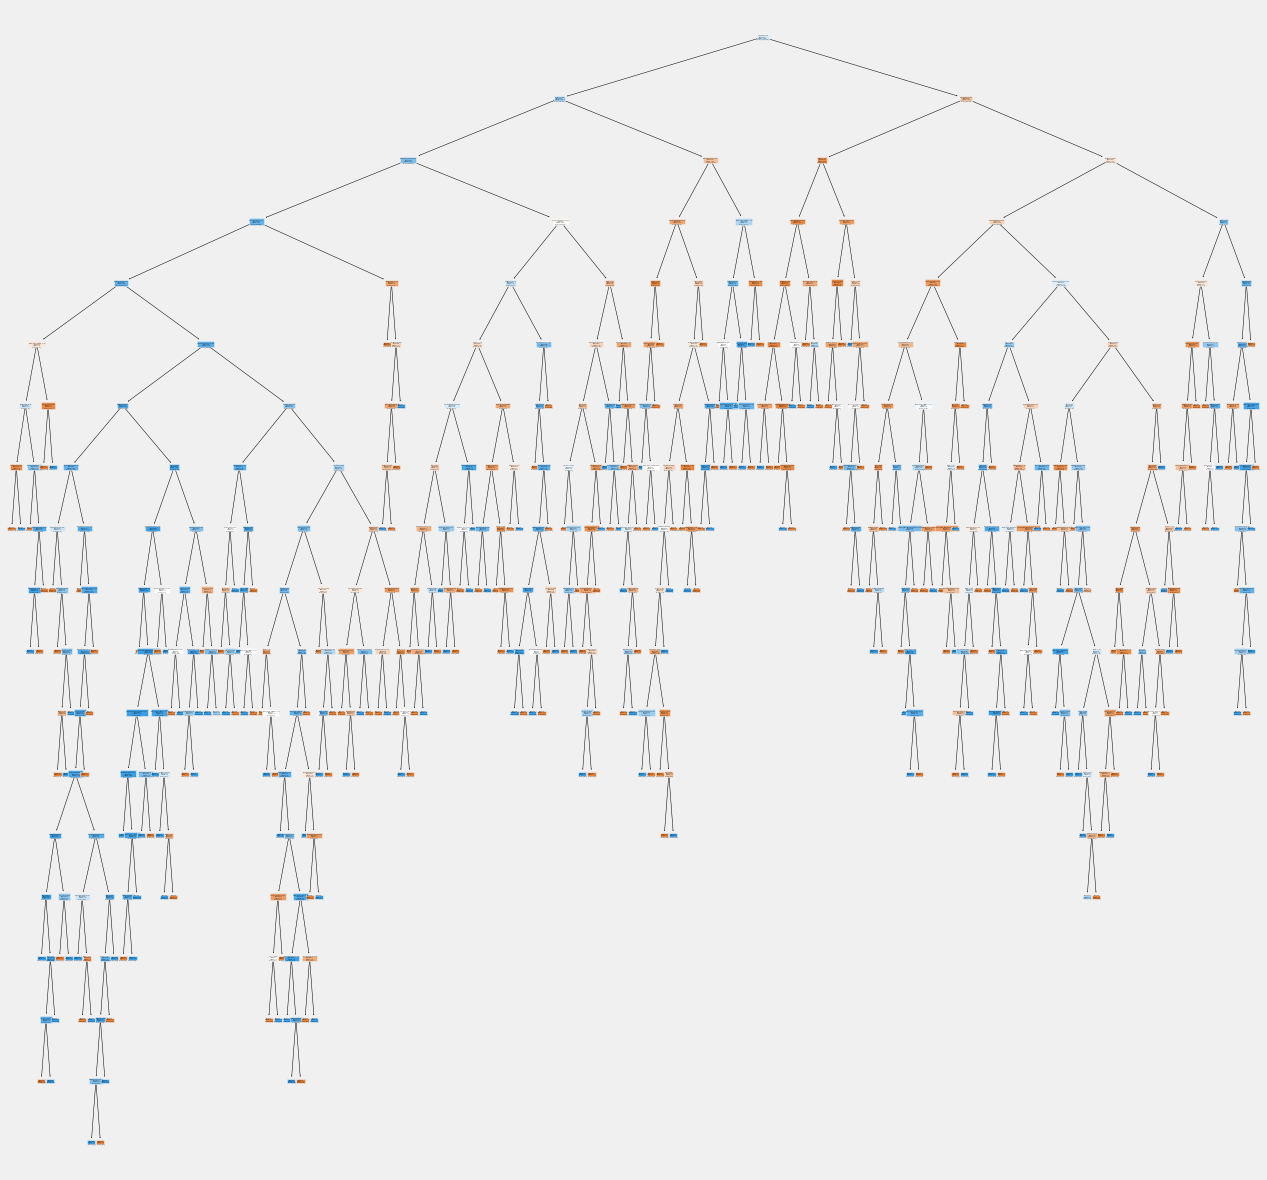

In [308]:
#Plotting a single tree.
plt.figure(figsize=(20,20))
_= tree.plot_tree(random_classifier.estimators_[1], feature_names=X_train.columns, filled=True)

#### **K-nearest Neighbor**

In [309]:
#KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=56)
knn_classifier.fit(X_train, y_train)
clf_prediction = knn_classifier.predict(X_test)

#Model Accuracy
print('KNN Model')
print(confusion_matrix(y_test, clf_prediction))
print(classification_report(y_test, clf_prediction))
print('Model Accuracy: ',accuracy_score(y_test, clf_prediction))

KNN Model
[[306 188]
 [183 352]]
              precision    recall  f1-score   support

           0       0.63      0.62      0.62       494
           1       0.65      0.66      0.65       535

    accuracy                           0.64      1029
   macro avg       0.64      0.64      0.64      1029
weighted avg       0.64      0.64      0.64      1029

Model Accuracy:  0.6394557823129252


#### **Logistic Regression**

In [310]:
from sklearn.linear_model import LogisticRegressionCV
#LOGISTIC REGRESSION MODEL
lr_classifier =  LogisticRegressionCV(cv=5, random_state=0)
lr_classifier.fit(X_train, y_train)
lr_prediction = random_classifier.predict(X_test)
    
#Model Accuracy
print('LOGISTIC REGRESSIONN')
print(confusion_matrix(y_test, lr_prediction))
print(classification_report(y_test, lr_prediction))
print('Model Accuracy: ',accuracy_score(y_test, lr_prediction))

LOGISTIC REGRESSIONN
[[470  24]
 [ 29 506]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       494
           1       0.95      0.95      0.95       535

    accuracy                           0.95      1029
   macro avg       0.95      0.95      0.95      1029
weighted avg       0.95      0.95      0.95      1029

Model Accuracy:  0.9484936831875608


#### **1.7 Test Model on final test set**

In [311]:
#Predicting Target values for final test set
predictions = random_classifier.predict(X_dev)

#Converting into pandas object
predictions = pd.DataFrame(predictions)
predictions.columns = ['Predictions']

#Creating a Datafame for the actual values
actual_values = pd.DataFrame(y_dev)
actual_values.columns = ['ActualValues']

#Join dataframes
results = actual_values.join(predictions)
results.head(15)

,ActualValues,Predictions
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,1,0
9,0,0


it´s observable that our model is very good. Let`s try to observe the % of good and bad predictions

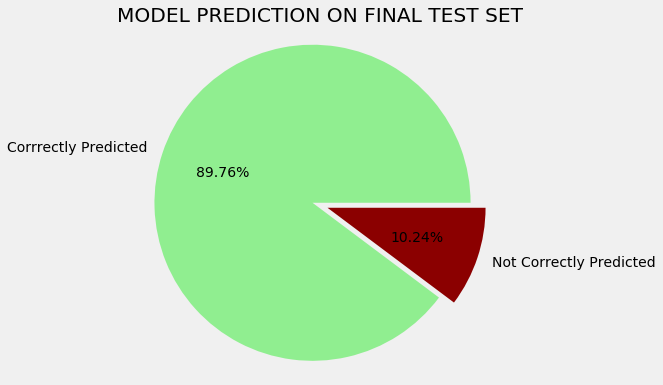

In [312]:
#Lets comparte the values of the columns and see if the predictions were true of vales
predicted = results['ActualValues'] == results['Predictions']

#Transform predicted into pandas DF
predicted = pd.DataFrame(predicted)
predicted.columns = ['True or False']

#Applying check function
predicted['True or False'] = predicted['True or False'].apply(checkFunc)

#Plot results
pred = predicted['True or False'].value_counts()
color = ['lightgreen','darkred']
plt.figure(figsize=(8,6))
plt.pie(pred,labels=pred.index,autopct='%1.2f%%',explode=(0,0.1),colors=color)
plt.title('MODEL PREDICTION ON FINAL TEST SET')
plt.axis('equal')
plt.show()

In [313]:
#Saving Random forest classifier model.
filename = 'marketing_response.pkl'
pickle.dump(random_classifier, open(filename, 'wb'))

### **2 Market Opportunity with Unsupervised Learning**

We want to segment our customers, to understand which customers have more potential to continue buying, or which need more attention, we will carry out a supervised algorithm with characteristics such as:

Recency: Date in months since the last purchase
Dt_customer: How long have you been affiliated with the company.
income: income.
 
and let's create a column where you show the total expenses you have made.

In [314]:
#Creating a new dataframe from the original
unsupervised = data

#Creating a new column based on spendings
unsupervised['TotalSpendings'] = unsupervised['MntWines'] + unsupervised['MntFruits']+ unsupervised['MntMeatProducts'] + unsupervised['MntFishProducts'] + unsupervised['MntSweetProducts'] +unsupervised['MntGoldProds']

#Creating a new column for customer enrolled from enrolled date, to last date of data
last_date = date(2014,10, 4)
unsupervised['Enrolled']=pd.to_datetime(unsupervised['Dt_Customer'], dayfirst=True,format = '%Y-%m-%d')
unsupervised['Enrolled'] = pd.to_numeric(unsupervised['Enrolled'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer')/30

#Create dataframe with this columns
marketing_data = unsupervised[['Enrolled','Income','TotalSpendings']]

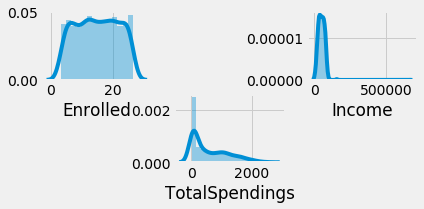

In [315]:
#Observing distribution

#  subplot #1
plt.subplot(331)
sns.distplot(marketing_data['Enrolled'])


#  subplot #2
plt.subplot(333)
sns.distplot(marketing_data['Income'])

#  subplot #3
plt.subplot(335)
sns.distplot(marketing_data['TotalSpendings'])

plt.show()

In [316]:
#some information about the data
marketing_data.describe()

,Enrolled,Income,TotalSpendings
count,2240.000000,2240.000000,2240.000000
mean,15.019405,52247.251354,605.798214
std,6.737417,25037.797168,602.249288
min,3.233333,1730.000000,5.000000
25%,9.258333,35538.750000,68.750000
50%,15.083333,51741.500000,396.000000
75%,20.866667,68289.750000,1045.500000
max,26.533333,666666.000000,2525.000000


average incomes 52247 dollars$

average total spendings 605 dollars$

15 months is the average of months enrolled for a customer

In [317]:
#Data normalize
scaler=StandardScaler()

#Normalizing values
X_std =scaler.fit_transform(marketing_data)
X = X_std

In [318]:
#Elbow curve values
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

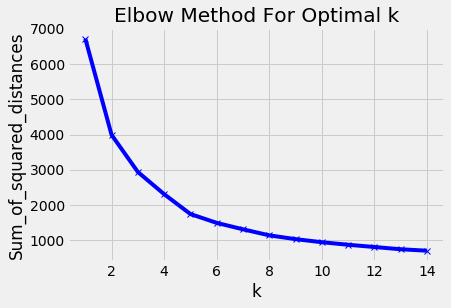

In [319]:
# Plot elbow curve.
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

 **3** is the optimal number of clusters

In [320]:
#fitting the K-means Algorithm
kmeans = KMeans(n_clusters=4,max_iter=100,random_state=0)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [321]:
#Adding Kmeans values to model_df
marketing_data['Kmeans'] = kmeans.labels_

In [322]:
#Getting unique labels 
u_labels = np.unique(y_kmeans)
#Getting centroinds
centroids = kmeans.cluster_centers_

#### **Plot Result**

In [323]:
# Dataframe with only the clusters
kmeans_values = marketing_data['Kmeans']
kmeans_values = pd.DataFrame(kmeans_values)
kmeans_values = kmeans_values.reset_index(drop=True)

# Applying Principal component to reduce dimensionality.
pca_a = PCA(n_components=2) # 2d pplot
pca_review = pca_a.fit_transform(X)

# Dataframe with Components and K_means Clusters
pca_review_df = pd.DataFrame(data= pca_review, columns= ['Component1','Component2'])
pca_data = pd.concat([pca_review_df, kmeans_values[['Kmeans']]],axis=1)

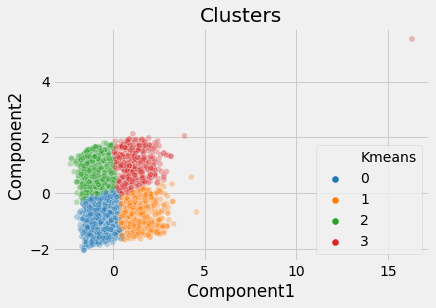

In [324]:
# Scatterplot
sns.scatterplot(
    x="Component1", y="Component2",
    hue='Kmeans',
    palette=sns.color_palette('tab10', 4),
    data=pca_data,
    legend="full",
    alpha=0.3
)
plt.title('Clusters')
plt.show()

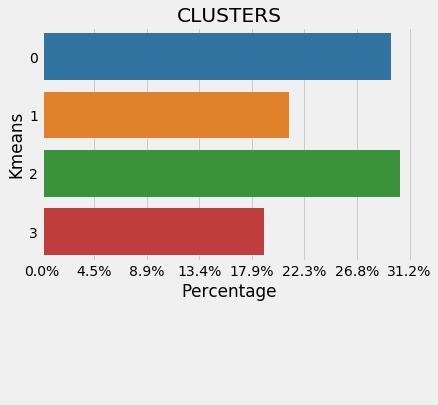

In [325]:
#Countplot
total = len(marketing_data['Kmeans'])*1.
ax = sns.countplot(y="Kmeans", data=marketing_data, palette='tab10')
plt.title('CLUSTERS')
plt.xlabel('Percentage')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_y()+0.1, p.get_height()+5))
_ = ax.set_xticklabels(map('{:.1f}%'.format, 100*ax.xaxis.get_majorticklocs()/total))

In [326]:
#Checking results from cluster
group = marketing_data.groupby('Kmeans').describe()
group = group.transpose()
group

Kmeans                           0              1             2              3
Enrolled       count    664.000000     471.000000    681.000000     424.000000
               mean      20.405572      21.240977      8.958248       9.408255
               std        3.504667       3.231235      3.341109       3.482609
               min       14.533333      13.800000      3.233333       3.233333
               25%       17.333333      18.466667      6.066667       6.525000
               50%       20.166667      21.200000      8.866667       9.433333
               75%       23.500000      24.150000     11.900000      12.275000
               max       26.533333      26.500000     14.866667      16.533333
Income         count    664.000000     471.000000    681.000000     424.000000
               mean   37213.535790   70898.075377  39406.245244   75696.718760
               std    13044.963005   12971.336805  13731.846326   31665.077415
               min     3502.000000    2447.000000   1730.000000   52247.251354
               25%    27867.500000   62845.000000  29604.000000   65701.750000
               50%    37284.000000   70356.000000  39190.000000   73013.500000
               75%    47352.000000   79158.500000  49681.000000   80126.500000
               max    66503.000000  160803.000000  71322.000000  666666.000000
TotalSpendings count    664.000000     471.000000    681.000000     424.000000
               mean     225.722892    1329.781316    141.361233    1142.721698
               std      209.764987     404.629793    148.230480     432.455005
               min        5.000000     497.000000      6.000000       6.000000
               25%       52.750000    1004.500000     41.000000     819.500000
               50%      135.500000    1282.000000     68.000000    1067.000000
               75%      377.000000    1596.500000    211.000000    1427.250000
               max      839.000000    2524.000000    725.000000    2525.000000

Cluster 0 = 2nd on enrolled time, 4th on Income ,3rd place on spendings.

Cluster 1 =  1st on enrolled time, 2nd on Income, 1st on spendings.

Cluster 2 = 4th on enrolled time, 3rth on Incomes, 4th on spendings.

Cluster 3  = 3rth on enrolled time, 1st on incomes, 2nd on spendings.

Cluster 0 is people with low incomes,and therefore they do not have as much money to buy. Therefore, low-cost products should be offered, since despite the aforementioned, they occupy second place in registered time, so they are loyal customers.

Cluster 1 They rank first in enrolled time, second in income, and first in purchases. Therefore, they are 5-star clients, loyal to the company and should be treated as luxury clients by offering them special campaigns as deluxe clients.

Cluster 2 They rank last in enrolled time, third in income, and last in spendigs. They need high attention, especially with accessible products for them.

Cluster 3 They rank third in enrolled time, but are first in income, and second in expenses. They have high potential since they have a high income, and they are quite new on average in the company, so an increase in campaigns in this sector could considerably increase sales.


Cluster 0 = Loyal

Cluster 1 = 5-Star

Cluster 2 = Need Attention

Cluster 3 = Highest Potential

In [327]:
# Renaming cluster names.
marketing_data['Kmeans'] = marketing_data['Kmeans'].apply(clusters)

#Separating cluster
cluster = marketing_data['Kmeans']
cluster = pd.DataFrame(cluster)
cluster.columns = ['CustomerSegmentation']

data = data.join(cluster)

In [330]:
# Creating a dataframe with the ID and type of customer
customer_segmentation = data[['ID','CustomerSegmentation']]
customer_segmentation.head(10)

,ID,CustomerSegmentation
0,5524,5-Star
1,2174,Need Attention
2,4141,Highest Potential
3,6182,Need Attention
4,5324,Need Attention
5,7446,Highest Potential
6,965,Loyal
7,6177,Loyal
8,4855,Loyal
9,5899,Need Attention


In [332]:
#Downloading as a csv fie
customer_segmentation.to_csv(r'C:\\Users\Asus\\Desktop\\marketing\\data\\customer_segmentation.csv')